In [1]:
import os
from pathlib import Path
import pickle
from time import time
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

from catch_converter.parse_contours import parse_cvi42ws
from LazyLuna.Mini_LL import *
from LazyLuna.CATCH_utils import *
from LazyLuna.network_comparison_utils import *

In [2]:
bp       = '/media/omega/Daten1/CATCH/CS'
bp_annos = '/media/omega/Daten1/CATCH/CS/Preds/FCN'
bp_cases = '/media/omega/Daten1/CATCH/CS/Cases'
bp_imgs  = '/media/omega/Daten1/CATCH/CS/Imgs'

In [3]:
# load cases
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'Annos' in p]
cases1 = [pickle.load(open(p, 'rb')) for p in case_paths]
case_paths = [os.path.join(bp_cases,p) for p in os.listdir(bp_cases) if p.endswith('.pickle') and 'UNet' in p and 'MRUNet' not in p]
cases2 = [pickle.load(open(p, 'rb')) for p in case_paths]
cases1 = sorted(cases1, key=lambda c: c.case_name)
cases2 = sorted(cases2, key=lambda c: c.case_name)
names = set([c.case_name for c in cases2])
cases1 = [c for c in cases1 if c.case_name in names]

crs1 = [(cr.name, cr.get_cr()) for c in cases1 for cr in c.crs]
crs2 = [(cr.name, cr.get_cr()) for c in cases2 for cr in c.crs]
print(crs1)
print(crs2)

[('LVESV', 44.669443431348675), ('LVEDV', 142.07685305146344), ('RVESV', 78.0639036578784), ('RVEDV', 156.56378064493146), ('LVSV', 97.40740962011478), ('LVEF', 68.55966156932405), ('RVSV', 78.49987698705306), ('RVEF', 50.13923186077136), ('LVMYOMASS', 90.10853059707495), ('RVMYOMASS', 0.0), ('LVESP', 10), ('RVESP', 10), ('LVEDP', 24), ('RVEDP', 24), ('LVEDP', 16), ('LVESV', 50.543292901524545), ('LVEDV', 120.27379943973227), ('RVESV', 88.1636782533624), ('RVEDV', 159.39130075213217), ('LVSV', 69.73050653820772), ('LVEF', 57.97647273425421), ('RVSV', 71.22762249876976), ('RVEF', 44.687270988576884), ('LVMYOMASS', 119.70478569589375), ('RVMYOMASS', 0.0), ('LVESP', 8), ('RVESP', 8), ('LVEDP', 24), ('RVEDP', 24), ('LVEDP', 17), ('LVESV', 78.54826014341235), ('LVEDV', 157.6117980400321), ('RVESV', 76.38141996895767), ('RVEDV', 149.83766646628754), ('LVSV', 79.06353789661976), ('LVEF', 50.16346420782322), ('RVSV', 73.45624649732987), ('RVEF', 49.02388580268419), ('LVMYOMASS', 122.1733275076

## Thoughts on Clustering
Preprocessing is essential: GIGO principle<br/>


### We are looking for qualitatively different clusters
* Cluster different contours independently <br/>
* Maybe cluster apical / midv / basal independently? <br/>
* Maybe remove data that wasn't segmented by at least one segmenter? <br/>

### Only cluster a subset of problematic segmentation comparisons
* Problematic can be defined as DSC < value (like 80%)<br/>
* Or HD > 2mm<br/>
* Remove 
* Etc. ...

### Normalize data
* Clustering assumes the existence and comparability of distances. Values must be normalized, we can't have dice in [0, 100] and slice depth percentage in [0, 1] and ml diff in [-14.7, 6.5].<br/>
* Subtract mean, Divide by std dev <br/>
* Possibly PCA whitening to remove collinearity of metrics

# Preprocessing functions

In [4]:
def contour_subset(table, cont_name):
    ret_table = table.copy()
    return ret_table[ret_table['contour name']==cont_name]

def dice_subset_segmentation_failures(table, value=80.0):
    ret_table = table.copy()
    return ret_table[ret_table['DSC']<value]

def hd_subset_segmentation_failures(table, value=2.0):
    ret_table = table.copy()
    return ret_table[ret_table['HD']>value]

def absmldiff_subset_segmentation_failures(table, value=2.0):
    ret_table = table.copy()
    return ret_table[ret_table['abs ml diff']>value]

def add_normalized_values(table):
    ret_table = table.copy()
    names = ['DSC', 'HD', 'ml diff', 'abs ml diff']
    data = ret_table[names].values.astype(np.float64)
    print('In add normalized values:')
    display(ret_table)
    print('Length of data: ', data.shape)
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    ret_table[[n+' normalized' for n in names]] = pd.DataFrame(data).values
    return ret_table

def add_pca_whitened_values(table):
    ret_table = table.copy()
    names = ['DSC', 'HD', 'ml diff', 'abs ml diff']
    data = ret_table[names].values.astype(np.float64)
    pca = PCA(whiten=True)
    whitened = pca.fit_transform(data)
    ret_table[['pca_whitened_'+str(n_i) for n_i in range(len(names))]] = pd.DataFrame(whitened).values
    return ret_table
    return ret_table

In [5]:
case_comps = [Case_Comparison(cases1[i], cases2[i]) for i in range(len(cases1))]
tables = [SAX_CINE_analyzer(cc).get_case_contour_comparison_pandas_dataframe(fixed_phase_first_reader=False) for cc in case_comps]
master_table = pd.concat([t for t in tables])
print('len(master_table): ', len(master_table))

len(master_table):  7744


# Myocardial Clustering

In [6]:
# Get myocardium subset
table = contour_subset(master_table, 'lv_myo')

# Get segmentation failures
print('All myos: ', len(table))
table = dice_subset_segmentation_failures(table, value=90.0)
print('Poor myos: ', len(table))

# Normalize this data
table = add_normalized_values(table)
table = add_pca_whitened_values(table)
print('New table columns: ', table.columns)
#display(table)

All myos:  968
Poor myos:  477
In add normalized values:


,case,reader1,reader2,sop1,sop2,category,slice,max_slices,depth_perc,phase1,phase2,contour name,DSC,HD,ml diff,abs ml diff,position1,position2,has_contour1,has_contour2
row_0103,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883440.348697,1.2.276.0.7230010.3.1.4.0.458.1575883440.348697,SAX LVES,7,16,0.437500,10,10,lv_myo,89.540606,2.266912,0.426651,0.426651,midv,midv,True,True
row_0108,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883440.348729,1.2.276.0.7230010.3.1.4.0.458.1575883440.348729,SAX LVES,12,16,0.750000,10,10,lv_myo,78.011066,3.201562,0.668980,0.668980,apical,apical,True,True
row_0113,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883438.348466,1.2.276.0.7230010.3.1.4.0.458.1575883438.348466,SAX LVED,1,16,0.062500,24,24,lv_myo,84.093573,2.334821,0.274624,0.274624,basal,basal,True,True
row_0115,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883433.347707,1.2.276.0.7230010.3.1.4.0.458.1575883433.347707,SAX LVED,3,16,0.187500,24,24,lv_myo,86.327386,1.835226,-1.407545,1.407545,midv,midv,True,True
row_0118,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883440.348745,1.2.276.0.7230010.3.1.4.0.458.1575883440.348745,SAX LVED,6,16,0.375000,24,24,lv_myo,88.969380,1.366768,0.280047,0.280047,midv,midv,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
row_0138,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145118,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145118,SAX LVED,12,18,0.666667,24,24,lv_myo,89.532549,1.550090,-0.137483,0.137483,midv,midv,True,True
row_0139,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.144949,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.144949,SAX LVED,13,18,0.722222,24,24,lv_myo,86.587169,1.583333,-0.837179,0.837179,midv,midv,True,True
row_0140,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145045,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145045,SAX LVED,14,18,0.777778,24,24,lv_myo,87.075380,1.293681,-0.213333,0.213333,midv,midv,True,True
row_0141,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420717.144260,1.3.6.1.4.1.53684.1.1.4.0.531.1590420717.144260,SAX LVED,15,18,0.833333,24,24,lv_myo,80.229608,2.239171,-0.862636,0.862636,midv,apical,True,True


Length of data:  (477, 4)
New table columns:  Index(['case', 'reader1', 'reader2', 'sop1', 'sop2', 'category', 'slice',
       'max_slices', 'depth_perc', 'phase1', 'phase2', 'contour name', 'DSC',
       'HD', 'ml diff', 'abs ml diff', 'position1', 'position2',
       'has_contour1', 'has_contour2', 'DSC normalized', 'HD normalized',
       'ml diff normalized', 'abs ml diff normalized', 'pca_whitened_0',
       'pca_whitened_1', 'pca_whitened_2', 'pca_whitened_3'],
      dtype='object')


In [7]:
display(table)

,case,reader1,reader2,sop1,sop2,category,slice,max_slices,depth_perc,phase1,...,has_contour1,has_contour2,DSC normalized,HD normalized,ml diff normalized,abs ml diff normalized,pca_whitened_0,pca_whitened_1,pca_whitened_2,pca_whitened_3
row_0103,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883440.348697,1.2.276.0.7230010.3.1.4.0.458.1575883440.348697,SAX LVES,7,16,0.437500,10,...,True,True,0.580799,-0.132543,0.287525,-0.409151,-0.580169,-0.138184,-0.369795,0.017101
row_0108,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883440.348729,1.2.276.0.7230010.3.1.4.0.458.1575883440.348729,SAX LVES,12,16,0.750000,10,...,True,True,0.149225,0.235033,0.425823,-0.239939,-0.149548,0.271204,-0.366786,-0.162254
row_0113,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883438.348466,1.2.276.0.7230010.3.1.4.0.458.1575883438.348466,SAX LVED,1,16,0.062500,24,...,True,True,0.376906,-0.105836,0.200764,-0.515308,-0.376849,-0.121555,-0.306682,-0.274846
row_0115,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883433.347707,1.2.276.0.7230010.3.1.4.0.458.1575883433.347707,SAX LVED,3,16,0.187500,24,...,True,True,0.460522,-0.302315,-0.759251,0.275781,-0.458888,-0.436383,0.716289,0.540361
row_0118,ECSPRESS-003,Annos,UNet,1.2.276.0.7230010.3.1.4.0.458.1575883440.348745,1.2.276.0.7230010.3.1.4.0.458.1575883440.348745,SAX LVED,6,16,0.375000,24,...,True,True,0.559417,-0.486549,0.203859,-0.511521,-0.558624,-0.488303,-0.438562,-0.010613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
row_0138,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145118,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145118,SAX LVED,12,18,0.666667,24,...,True,True,0.580497,-0.414453,-0.034426,-0.611069,-0.579872,-0.472899,-0.193545,-0.204160
row_0139,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.144949,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.144949,SAX LVED,13,18,0.722222,24,...,True,True,0.470246,-0.401379,-0.433743,-0.122490,-0.469102,-0.494992,0.286797,0.195036
row_0140,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145045,1.3.6.1.4.1.53684.1.1.4.0.531.1590420718.145045,SAX LVED,14,18,0.777778,24,...,True,True,0.488521,-0.515292,-0.077713,-0.558105,-0.487892,-0.564819,-0.184539,-0.175638
row_0141,ECSPRESS171,Annos,UNet,1.3.6.1.4.1.53684.1.1.4.0.531.1590420717.144260,1.3.6.1.4.1.53684.1.1.4.0.531.1590420717.144260,SAX LVED,15,18,0.833333,24,...,True,True,0.232270,-0.143453,-0.448271,-0.104714,-0.231814,-0.239358,0.384765,-0.037740


## Scatter plot of metric values and normalized metric values

### Add visualization techniques here
* PCA direction arrows
* Show comparison for point in axis

<AxesSubplot:title={'center':'Dice vs HD'}, xlabel='DSC', ylabel='HD'>

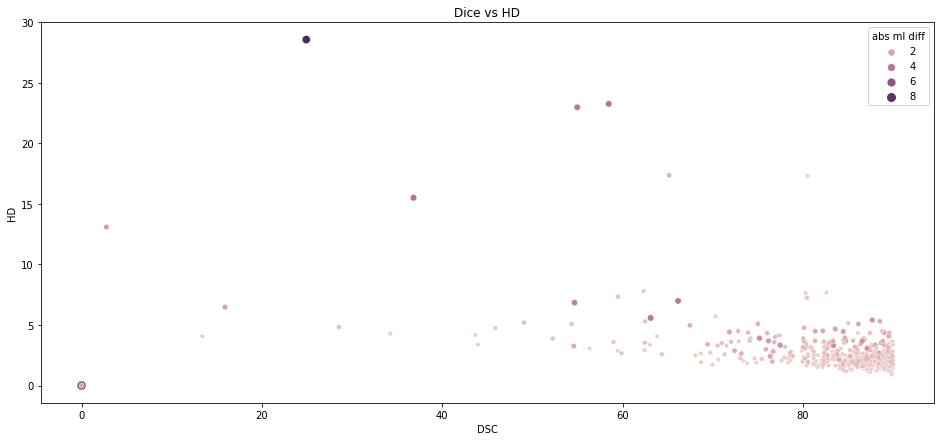

In [8]:
fig, axes = plt.subplots(1,1,figsize=(16,7))
axes.set_title('Dice vs HD')
sns.scatterplot(ax=axes, data=table, x='DSC', y='HD', hue='abs ml diff', size='abs ml diff')

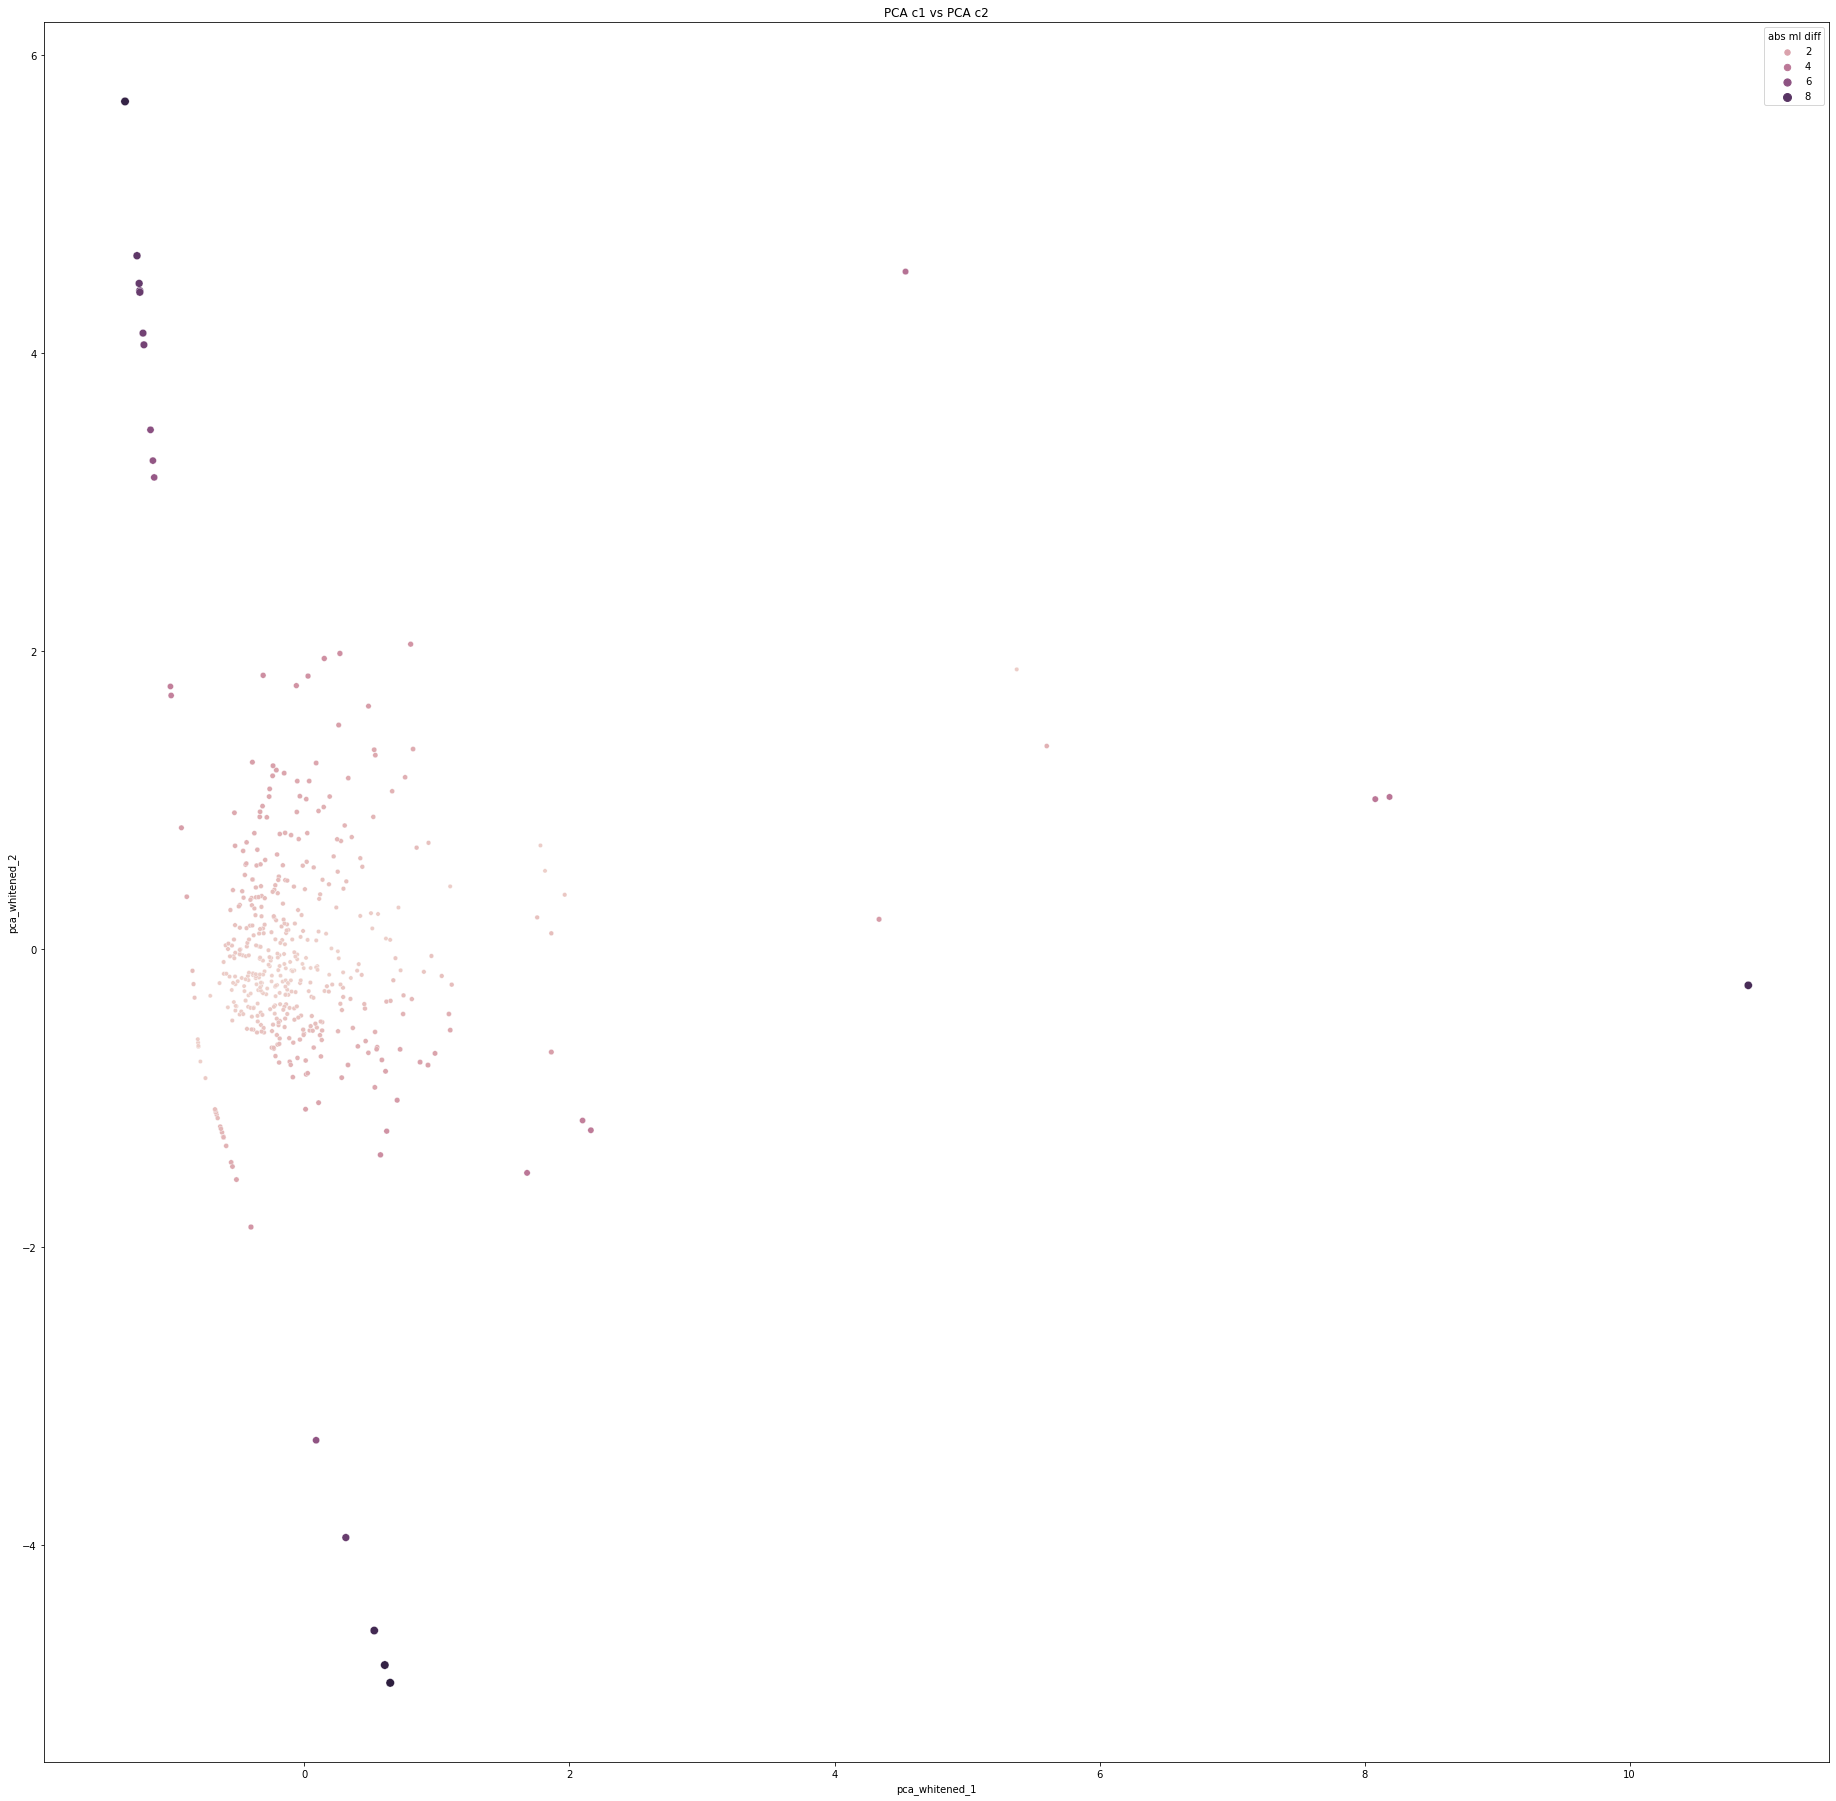

In [9]:
%matplotlib inline

fig, axes = plt.subplots(1,1,figsize=(32,32))
axes.set_title('PCA c1 vs PCA c2')
sns.scatterplot(ax=axes, data=table, x='pca_whitened_1', y='pca_whitened_2', 
                size='abs ml diff', hue='abs ml diff', picker=4)

def onpick(event):
    ind = event.ind
    print('onpick: ', ind)
    case_name  = table.iloc[ind]['case'].values[0]
    phase      = table.iloc[ind]['category'].values[0]
    reader1    = table.iloc[ind]['reader1'].values[0]
    reader2    = table.iloc[ind]['reader2'].values[0]
    slice_nr   = table.iloc[ind]['slice'].values[0]
    cont_name  = table.iloc[ind]['contour name'].values[0]
    sop1, sop2 = table.iloc[ind]['sop1'].values[0], table.iloc[ind]['sop2'].values[0]
    
    cc     = [cc for cc in case_comps if cc.case1.case_name==case_name][0]
    c1, c2 = cc.case1, cc.case2
    img    = c1.load_dcm(sop1).pixel_array
    cont1, cont2 = c1.load_anno(sop1).get_contour(cont_name), c2.load_anno(sop2).get_contour(cont_name)
    
    fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
    fig.suptitle(case_name + ', Phase: ' + str(phase) + ', Slice: ' + str(slice_nr))
    for i in range(3): ax[i].imshow(img); ax[i].axis('off')
    ax[0].set_title(reader1); ax[2].set_title(reader2)
    CATCH_utils.plot_outlines(ax[0], cont1); CATCH_utils.plot_outlines(ax[2], cont2)
    CATCH_utils.plot_geo_face_comparison(ax[1], cont1, cont2)
    fig.tight_layout()
    plt.show()
    
fig.canvas.mpl_connect('pick_event', onpick)
plt.show()